# Bank churn predictions - classification using ANN

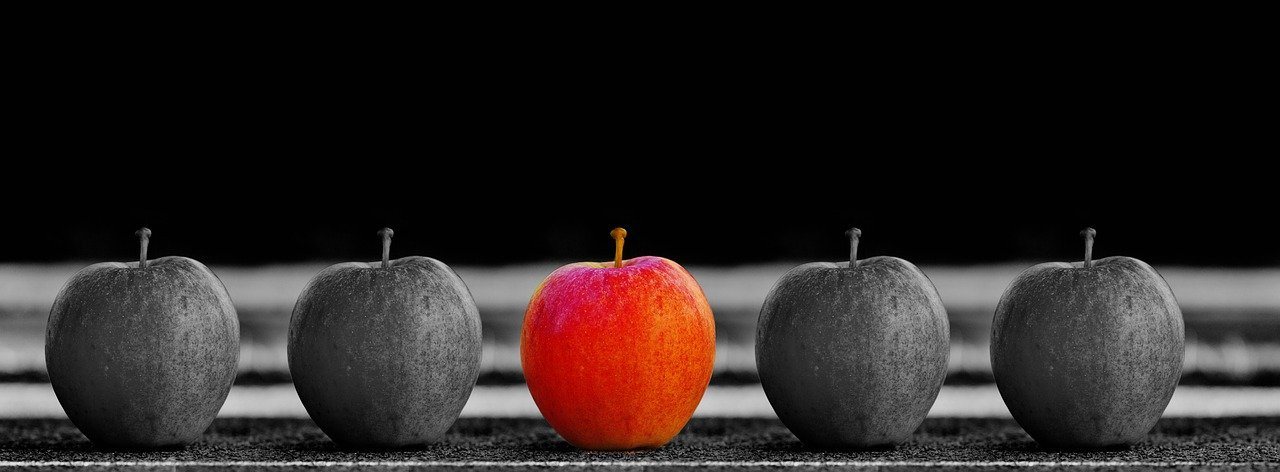

## Background and Context

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

## Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

## Data Description

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

## Data Dictionary

1. CustomerId: Unique ID which is assigned to each customer
2. Surname: Last name of the customer 
3. CreditScore: It defines the credit history of the customer.  
4. Geography: A customer’s location    
5. Gender: It defines the Gender of the customer   
6. Age: Age of the customer     
7. Tenure: Number of years for which the customer has been with the bank
8. NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
9. Balance: Account balance
10. HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
11. EstimatedSalary: Estimated salary 
12. isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
13. Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
    0=No ( Customer did not leave the bank )
    1=Yes ( Customer left the bank )

## Import required libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)

%load_ext nb_black

# library to suppress warnings or deprecation notes
import warnings

warnings.filterwarnings("ignore")

# libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# library to split data
from sklearn.model_selection import train_test_split, StratifiedKFold

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# remove the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# set the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

from sklearn import metrics

# library to encoding
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# to tune different models
from sklearn.model_selection import train_test_split

# to get diferent metric scores
from sklearn.metrics import (
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)

#import tenorflow
import tensorflow as tf
from tensorflow import keras as K

# Using Tensorflow Keras instead of the original Keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

<IPython.core.display.Javascript object>

## Define all required functions

In [2]:
# histogram and boxplot for the feature
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="orange"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="Winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color="blue", linestyle="-")
    plt.show()  # show the plot

# labeled_barplot
def labeled_barplot(data, feature, perc=False, v_ticks=True, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    if v_ticks is True:
        plt.xticks(rotation=90)
        
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    plt.show()  # show the plot

# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()
    
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\n  Accuracy = {:0.3f} Precision = {:0.3f} Recall = {:0.3f} F1 Score = {:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# calculate different metric scores of the model - Accuracy, Recall, F1 and Precision
def get_metrics_score(model,flag=True):
    """
    model : classifier to predict values of X

    """
    # defining an empty list to store results
    score_list=[] 
    accuracy_list=[]
    precision_list=[]
    recall_list=[]
    f1_list=[]
    
    # predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    # accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    # recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    # precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    # f1_score of the model
    train_f1 = metrics.f1_score(y_train,pred_train)
    test_f1 = metrics.f1_score(y_test,pred_test)

    # populate the score_list 
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,
                        test_precision,train_f1,test_f1))

    #list per data set
    accuracy_list.extend((train_acc,test_acc))
    recall_list.extend((train_recall,test_recall))
    precision_list.extend((train_precision,test_precision))
    f1_list.extend((train_f1,test_f1))

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 

        print("Accuracy on training set : ",train_acc)
        print("Accuracy on test set : ",test_acc)
        print("Recall on training set : ",train_recall)
        print("Recall on test set : ",test_recall)
        print("Precision on training set : ",train_precision)
        print("Precision on test set : ",test_precision)
        print("F1 on training set : ",train_f1)
        print("F1 on test set : ",test_f1)

    model_df = pd.DataFrame({"DataSet":["Training", "Testing"], 
                                          "Accuracy": accuracy_list, "Recall": recall_list,
                                          "Precision": precision_list,"F1": f1_list}) 

    return model_df, score_list  # returning the list with train and test scores

<IPython.core.display.Javascript object>

## Load the dataset

In [3]:
# load the file using read_csv. RowNumber column in the data can be used as index_col
df = pd.read_csv("bank.csv", index_col="RowNumber")

# back up data to preserve the initial version for reference
df_back = df.copy()

<IPython.core.display.Javascript object>

## Understand the data

### Shape of data

In [4]:
# print the data set information as number of rows and columns
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")  # f-string

There are 10000 rows and 13 columns.


<IPython.core.display.Javascript object>

### Dataset information

In [5]:
# check the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


<IPython.core.display.Javascript object>

**Observations:**
1. There are 13 columns in the dataset.
2. There are no NULL values as all columns have 10000 entries.
3. Geography and Gender are of object type and can be used for onehot encoding.
4. All columns with numerical data are of int and float types and no conversion required.
5. Surname column needs to analysed.

### Check duplicates

In [6]:
# check duplicate records
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

**Observations:**

There are no duplicates in the data.

### Check NULL values

In [7]:
# precentage of missing values in columns
round(df.isna().sum() / df.isna().count() * 100, 2)

CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

<IPython.core.display.Javascript object>

**Observations:**

There are no null values in the data.

### Sample data

In [8]:
# setting the random seed via np.random.seed to get the same random results every time
np.random.seed(1)

# also look at random 10 sample rows
df.sample(n=10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
9954,15655952,Burke,550,France,Male,47,2,0.00,2,1,1,97057.28,0
3851,15775293,Stephenson,680,France,Male,34,3,143292.95,1,1,0,66526.01,0
4963,15665088,Gordon,531,France,Female,42,2,0.00,2,0,1,90537.47,0
3887,15720941,Tien,710,Germany,Male,34,8,147833.30,2,0,1,1561.58,0
5438,15733476,Gonzalez,543,Germany,Male,30,6,73481.05,1,1,1,176692.65,0
8518,15671800,Robinson,688,France,Male,20,8,137624.40,2,1,1,197582.79,0
2042,15709846,Yeh,840,France,Female,39,1,94968.97,1,1,0,84487.62,0
1990,15622454,Zaitsev,695,Spain,Male,28,0,96020.86,1,1,1,57992.49,0
1934,15815560,Bogle,666,Germany,Male,74,7,105102.50,1,1,1,46172.47,0


<IPython.core.display.Javascript object>

**Observations:**

1. RowNumber looks like record tracking number and can be ignored. We have already considered the same as rownum variable in our dataframe and there is no need to handle the same.
2. CustomerID is unique appears to be the unique system identifier generated and would not add any value in our analysis. We can drop the same.
3. Surname is demographic information and doesn't really add value in identifying if the customer will continue with the bank.
4. Geography variable contains the name of the Country where customer resides / belongs to. This information can add value to analysis and identify if the Country has any influence on customer behavior. However we can do one hot encoding of the variable.
5. Exited is the target column and contains numerical data. We can use the same without any processing or handling.
6. All other variables look OK.


### Drop the CustomerID and Surname columns

We have seen in sample data that CustomerID and Surname data doesn't really add value to our analysis and we can drop the same.

In [9]:
# drop unused features
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

<IPython.core.display.Javascript object>

### Check basic statistics

In [10]:
# let"s view the statistical summary of the numerical columns in the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


<IPython.core.display.Javascript object>

**Observations:**

1. There are no extreme values in the dataset for the numerical variables.
2. We will revalidate the same during our Univariate analysis of each variable.

### Distribution of categorical features

In [11]:
# Summarize categorical features
df.describe(include=['object'])

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


<IPython.core.display.Javascript object>

**Observations:**

1. Geography variable shows that around 50% data is for customers from France.
2. Gender data shows that most records are for Male customers.

### Check unique values

In [12]:
# create categorical columns list
cat_cols = df.select_dtypes(exclude=["int64", "float64"])

# create numberical columns list
num_cols = df.select_dtypes(include=["int64", "float64"])
num_cols.drop('Exited', axis = 1, inplace = True)

<IPython.core.display.Javascript object>

In [13]:
#get the valuecounts
for i in cat_cols:
    print(df[i].value_counts())
    print("-"*50)
    print("\n")

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
--------------------------------------------------


Male      5457
Female    4543
Name: Gender, dtype: int64
--------------------------------------------------




<IPython.core.display.Javascript object>

**Observations:**

1. The data contains three Countries and France contributes to 50%.
2. Gender data also looks normal and male customers contribute to 50% in the dataset.

## Univarite Analysis

### CreditScore

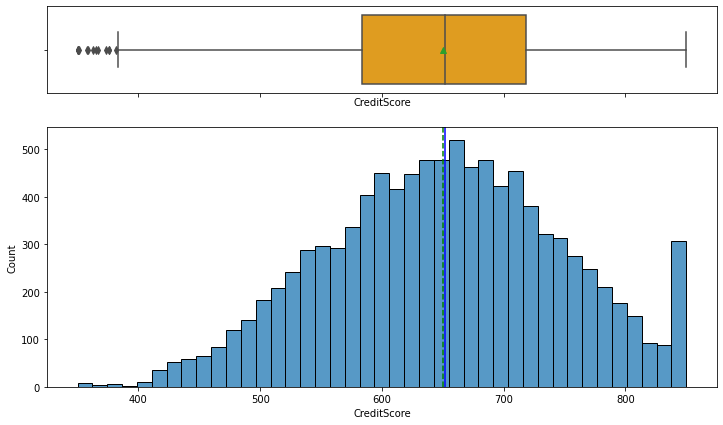

<IPython.core.display.Javascript object>

In [14]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"CreditScore") 

**Observations:**

1. CreditScore shows a nearly normal distribution with few outliers on the left. This means some customers have less credit score.
2. Considering the domain the data looks legitimate and can be used as is without outliers treatment.

### Geography

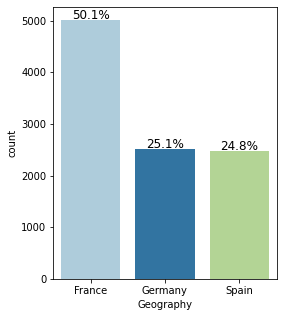

<IPython.core.display.Javascript object>

In [15]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Geography", True, False) 

**Observations:**

Majority of customers are from France, about 50%, and from Germany and Spain around 25% each.

### Gender

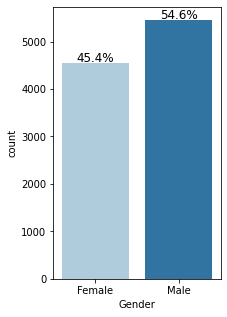

<IPython.core.display.Javascript object>

In [16]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Gender", True, False) 

**Observations:**

In our data sample there are more males than females.

### Age

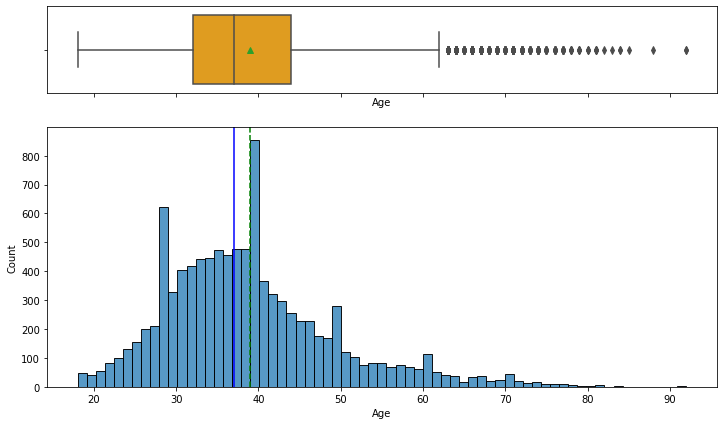

<IPython.core.display.Javascript object>

In [17]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Age") 

**Observations:**

1. Age shows a right tail, which means there are customers older than 60 years of age.
2. Considering the domain this data looks OK and be used as is.

### Tenure

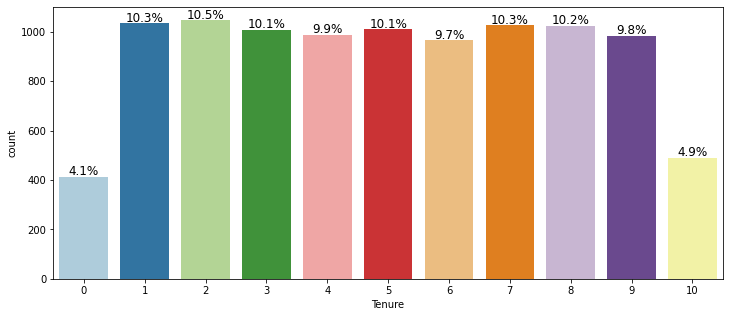

<IPython.core.display.Javascript object>

In [18]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Tenure", True, False) 

**Observations:**

1. Tenure shows normal distribution of data.
2. Few records have tenure less than 1 year, this is possibly due to new customers.
3. Data also shows that there are around 5% customers that are associated with Bank for 10 years or more.

### Balance

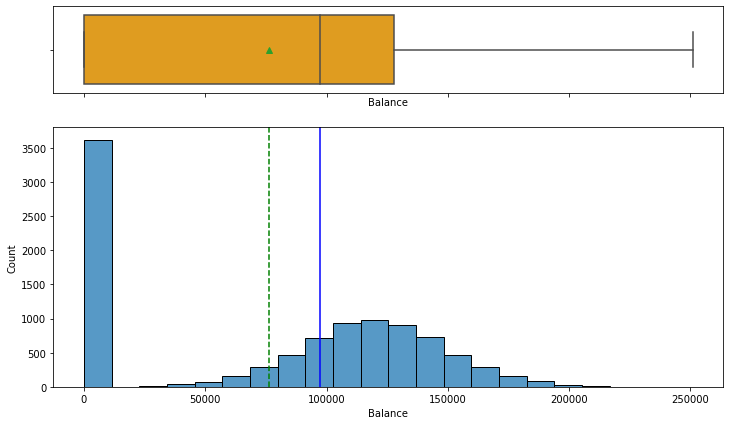

<IPython.core.display.Javascript object>

In [19]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Balance")

**Observations:**

1. Balance shows rightward tail with few outliers on the higher side.
2. The data looks legitimate as some customers may have more balance than others.

### NumOfProducts

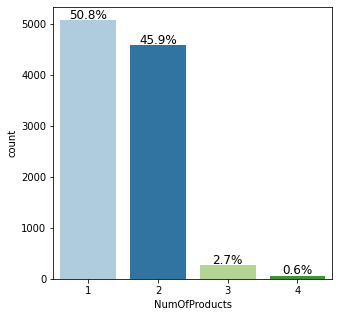

<IPython.core.display.Javascript object>

In [20]:
# use label_barplot function to plot the graph
labeled_barplot(df,"NumOfProducts", True, False) 

**Observations:**

1. Most customers have 4 products from the bank followed by customers with 2 products.
2. There are very few customers with 3 or more products.

### HasCrCard

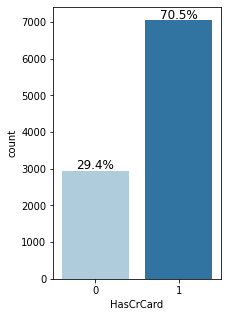

<IPython.core.display.Javascript object>

In [21]:
# use label_barplot function to plot the graph
labeled_barplot(df,"HasCrCard", True, False) 

**Observations:**

Majority of customers have Credit Card.

### IsActiveMember

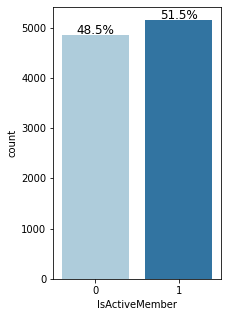

<IPython.core.display.Javascript object>

In [22]:
# use label_barplot function to plot the graph
labeled_barplot(df,"IsActiveMember", True, False) 

**Observations:**

More than 50% customers are active and use bank products regularly.

### EstimatedSalary

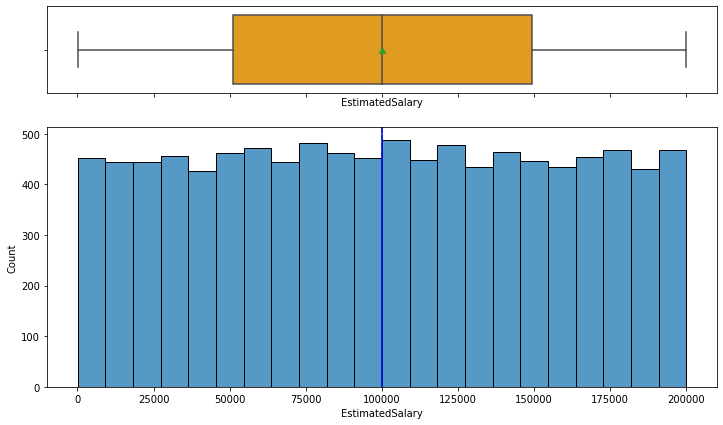

<IPython.core.display.Javascript object>

In [23]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"EstimatedSalary") 

**Observations:**

Estimated salary shows normal distribution.

### Exited - target variable

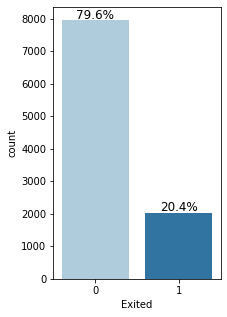

<IPython.core.display.Javascript object>

In [24]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Exited", True, False) 

**Observations:**

1. The data shows only 20% customers have left the bank.
2. The business should confirm that this is complete data / include more data for Exited customers to make a robust model to identify whether the customer will leave the bank.

## Bivariate Analysis

### Pairplot of all variables with impact on target variable

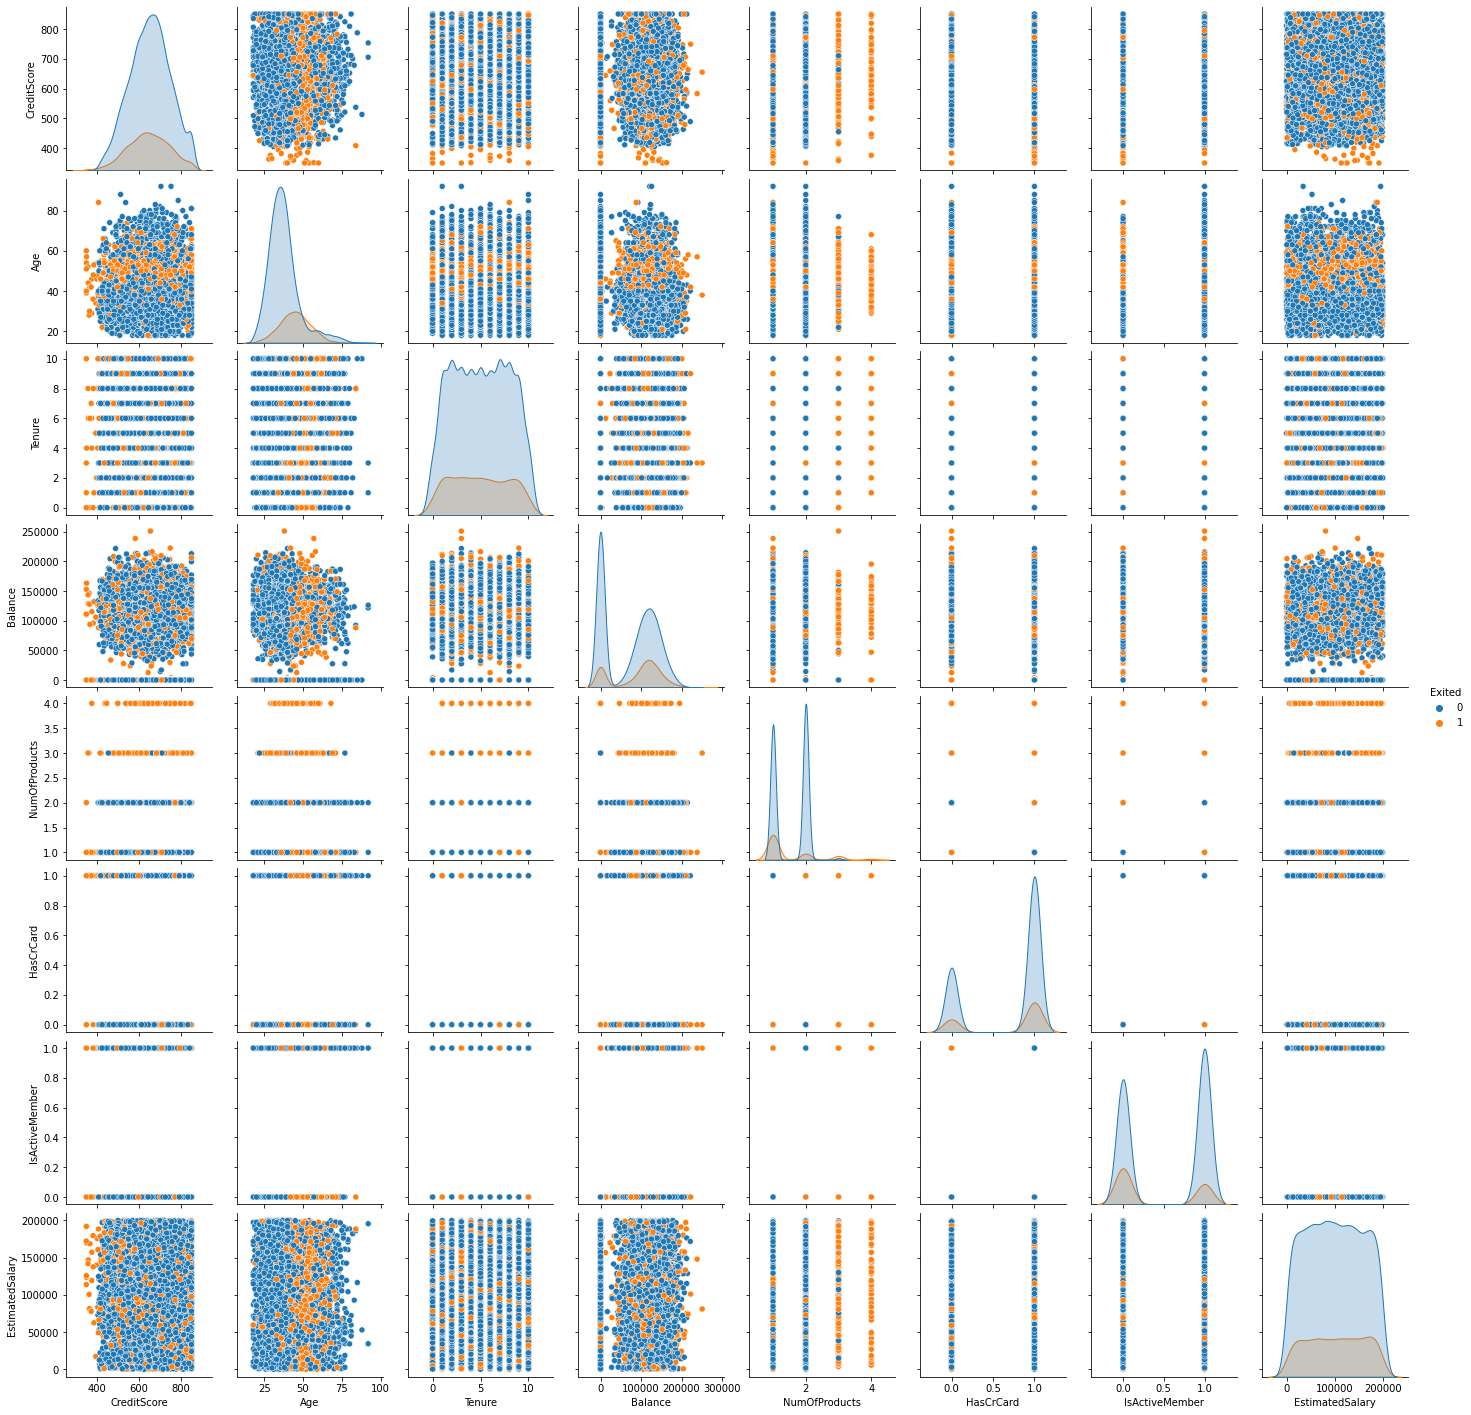

<IPython.core.display.Javascript object>

In [25]:
#draw the pairplot
sns.pairplot(df, diag_kind='kde', hue='Exited')
plt.show()

**Observations:**

1. CreditScore, NumOfProducts, HasCrCard, IsActiveMember and EstimatedSalary doesn't seem to be impacting customers decisions to leave / stay with bank.
2. Customers with 35 years of age and above tend to leave the bank.
3. Tenure of the customer relationship with the bank shows some impact and customer with data showing customer ranging 2-8 years have left the bank.
4. Few customers with higher balances have left the bank, otherwise the data is not alarming.

### Correlation of numeric features with target variable

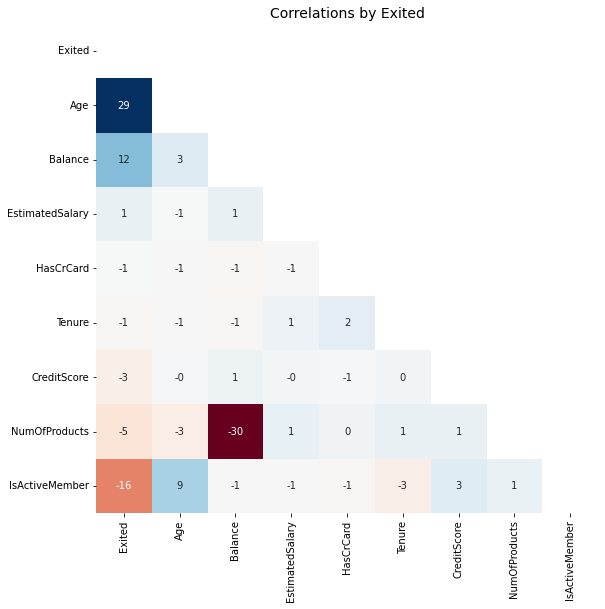

<IPython.core.display.Javascript object>

In [26]:
# Calculate correlations between numeric features
correlations = df.corr()

# sort features in order of their correlation with "Exited"
sort_corr_cols = correlations.Exited.sort_values(ascending=False).keys()
sort_corr = correlations.loc[sort_corr_cols,sort_corr_cols]

# Generate a mask for the upper triangle
corr_mask = np.zeros_like(correlations)
corr_mask[np.triu_indices_from(corr_mask)] = 1

# Make the figsize 9x9
plt.figure(figsize=(9,9))

# Plot heatmap of annotated correlations; change background to white
##with sns.axes_style('white'):
sns.heatmap(sort_corr*100, 
                cmap='RdBu', 
                annot=True,
                fmt='.0f',
                mask=corr_mask,
                cbar=False)
    
plt.title('Correlations by Exited', fontsize=14)
plt.yticks(rotation=0)
plt.show()

**Observations:**

1. Very weak correlations in general. 
2. Only weak positive correlation with age.
3. Very weak positive correlation with balance.
4. Very weak negative correlations with number of products and membership.

### Comparison of all numerical variables with target variable

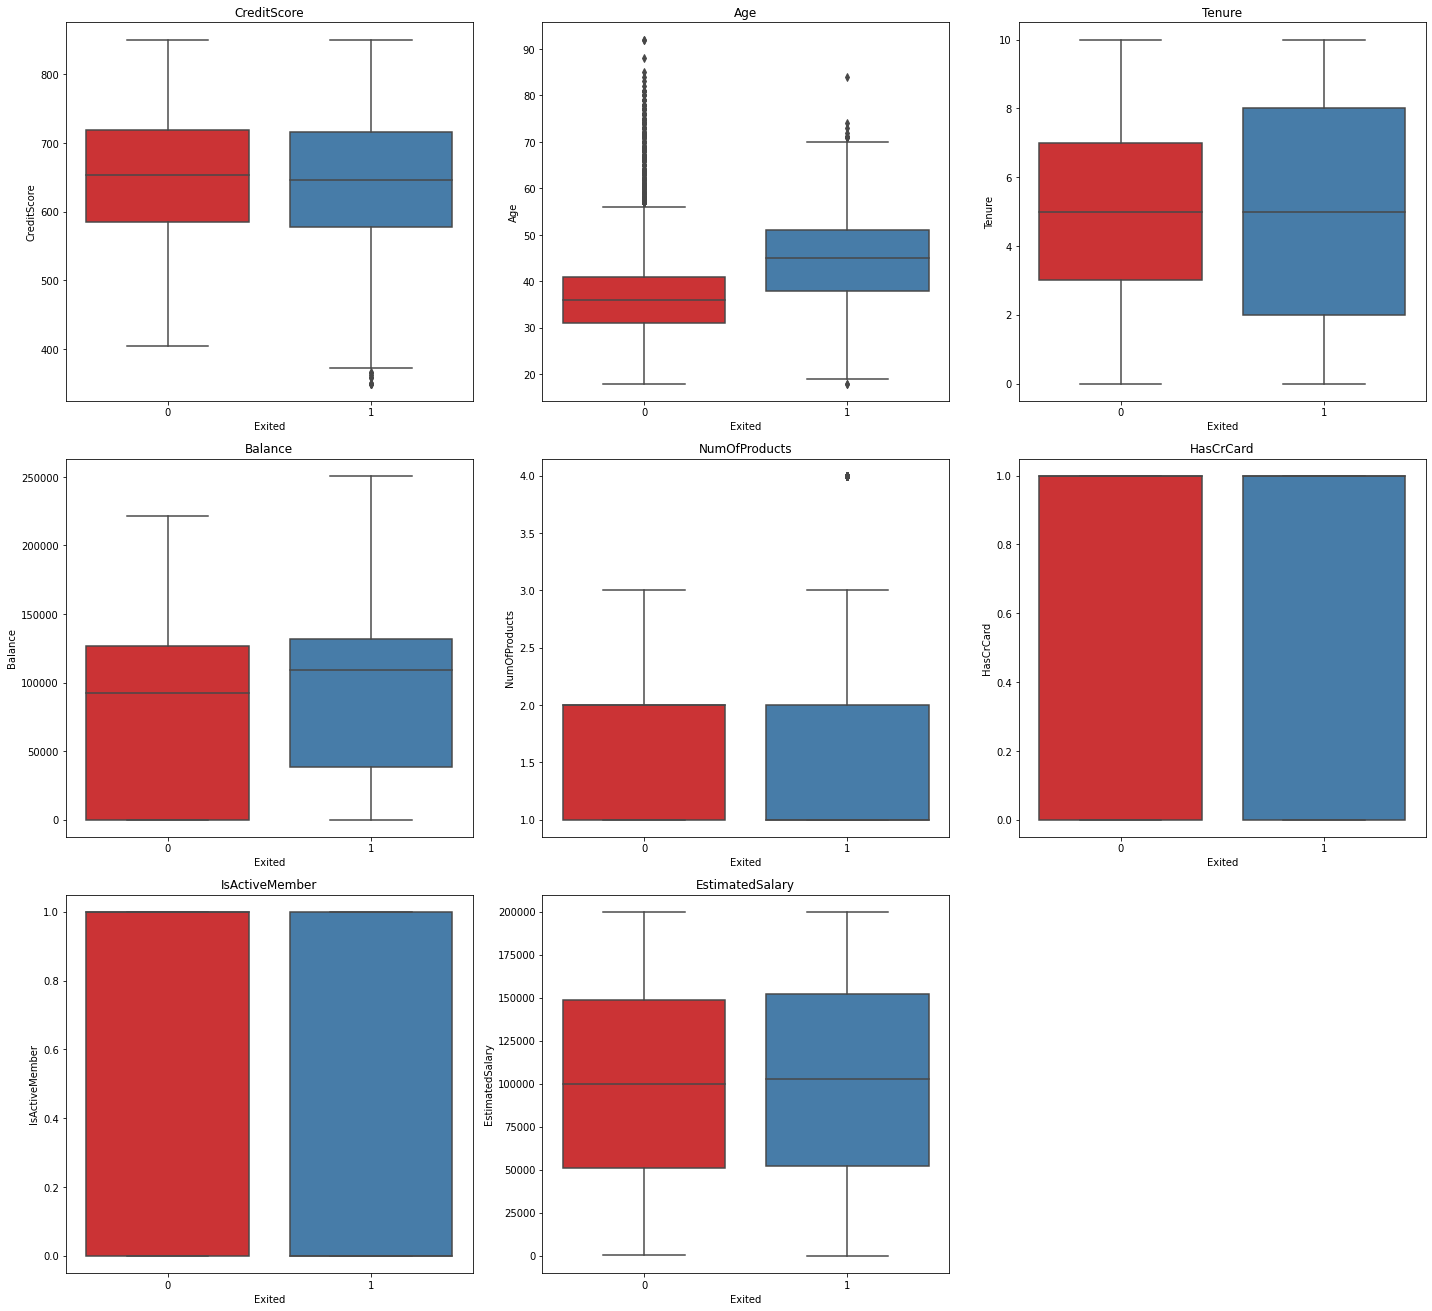

<IPython.core.display.Javascript object>

In [27]:
# for all numerical variables draw box plots
plt.figure(figsize=(20,30))
for i, variable in enumerate(num_cols):
                     plt.subplot(5,3,i+1)
                     sns.boxplot(df["Exited"],df[variable],palette="Set1")
                     plt.tight_layout()
                     plt.title(variable)
plt.show()

**Observations:**

1. CreditScore, NumOfProducts, HasCrCard, IsActiveMember and EstimatedSalary doesn't seem to be impacting customers decisions to leave / stay with bank.
2. Customers with 35 years of age and above tend to leave the bank.
3. Tenure of the customer relationship with the bank shows some impact and customer with data showing customer ranging 2-8 years have left the bank.
4. Few customers with higher balances have left the bank, otherwise the data is not alarming.

### Gender VS Exited

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


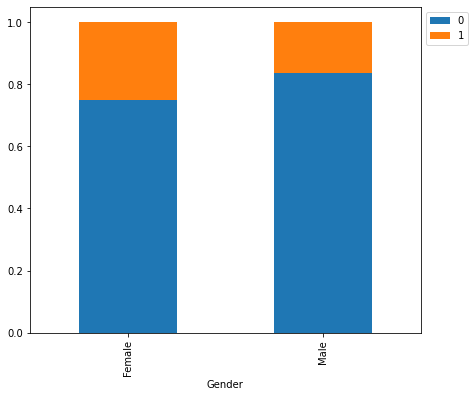

<IPython.core.display.Javascript object>

In [28]:
# use the defined function stacked_barplot to plot the graphs
stacked_barplot(df, "Gender", "Exited")

**Observations:**

The dataset contains more than 50% data of male customers however there is marginal difference in numbers when compared to target variable.

### Geography VS Exited

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


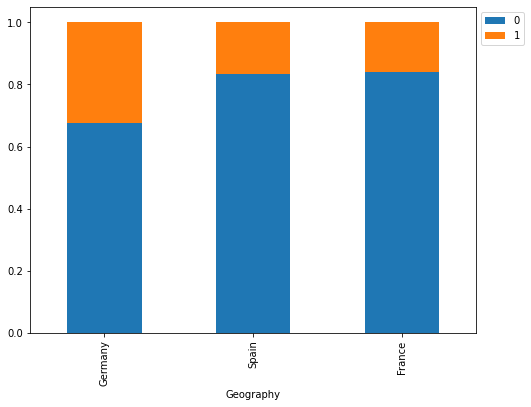

<IPython.core.display.Javascript object>

In [29]:
# use the defined function stacked_barplot to plot the graphs
stacked_barplot(df, "Geography", "Exited")

**Observations:**

Customer from Germany are more likely to leave the bank compared to other countries.

## Outliers treatment

### Draw boxplots for outliers in numerical columns

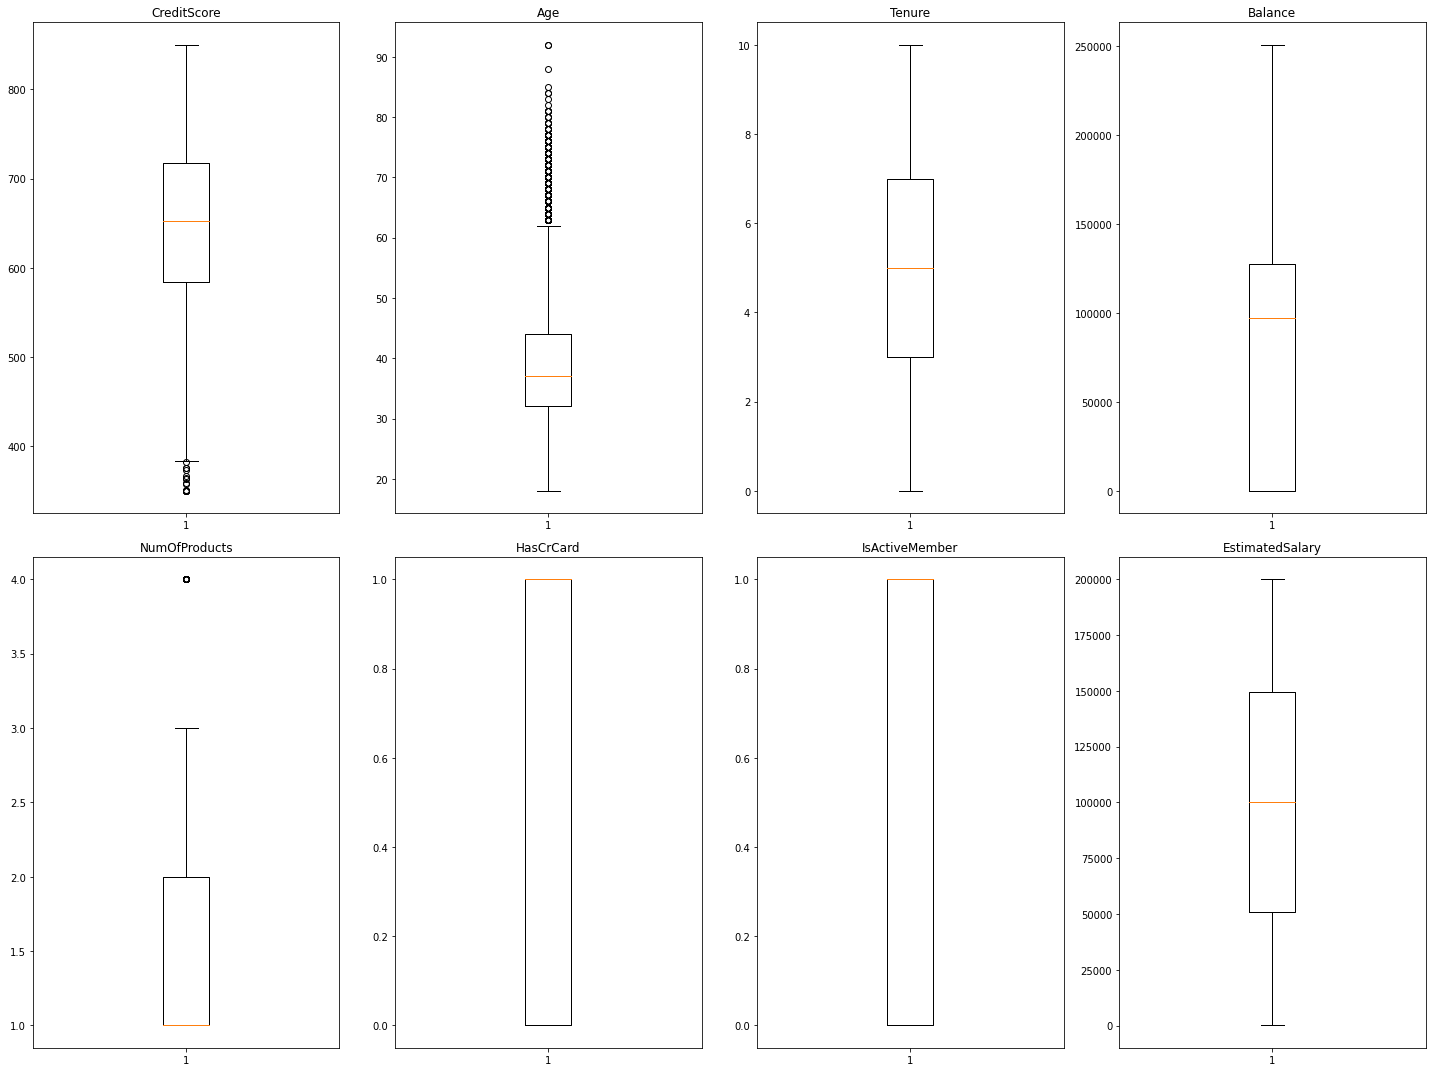

<IPython.core.display.Javascript object>

In [30]:
# check the outliers before treating
plt.figure(figsize=(20, 15))

for i, variable in enumerate(num_cols):
    plt.subplot(2, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

**Observations:**

1. Age and CreditScore shows outliers, however considering the domain the data seems legitimate and no treatment required.
2. Also considering the ANN Models we are trying to build the outliers will be handled during data re-scaling.

## Data pre-processing

### Define the dependent and independent variables


In [31]:
# defining the dependent and independent variables
X = df.drop(["Exited"], axis=1)
y = df["Exited"]

<IPython.core.display.Javascript object>

### Encode the Categorical columns

In [32]:
# handle categorical variables:
# transform Geography
geography=pd.get_dummies(X['Geography'],drop_first=True)

#transform Gender
gender=pd.get_dummies(X['Gender'],drop_first=True)

#concat the new variables into the dataset
X=pd.concat([X,geography,gender],axis=1)

#drop column which are redundant and of no use
X=X.drop(['Geography','Gender'],axis=1)

<IPython.core.display.Javascript object>

In [33]:
# check the sample data after encoding
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
RowNumber,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,0,0,0
2,608,41,1,83807.86,1,0,1,112542.58,0,1,0
3,502,42,8,159660.80,3,1,0,113931.57,0,0,0
4,699,39,1,0.00,2,0,0,93826.63,0,0,0
5,850,43,2,125510.82,1,1,1,79084.10,0,1,0


<IPython.core.display.Javascript object>

**Observations:**

We see that the data is encoded and it is now ready for modelling.

### Split the dataset in train and test (70:30)

In [34]:
# splitting data into training and test set, use stratify to maintain the original distribution of Dependent variable as of original set
X_train,X_test, y_train, y_test =train_test_split(X,y, test_size=0.3, random_state=1,stratify=y)

<IPython.core.display.Javascript object>

### Scale the features

In [35]:
# use StandardScaler() to transform the train and test sets
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

<IPython.core.display.Javascript object>

## Model building

**Before building ANN let us try and build RandomForestClassifier model to check the accuracy**

In [36]:
# instantiate RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)

# fit the model
# Pandas Series.ravel() function returns the flattened underlying data as an ndarray.
random_forest.fit(X_train,y_train.values.ravel())  

# predict the performance on testing dataset
y_pred = random_forest.predict(X_test)

<IPython.core.display.Javascript object>

#### Check the scores

In [37]:
# check accuracy scores
score = random_forest.score(X_test,y_test)
score

0.8623333333333333

<IPython.core.display.Javascript object>

#### Print the Confusion Matrix

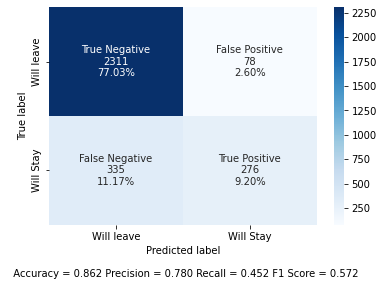

<IPython.core.display.Javascript object>

In [38]:
# use make_confusion_matrix to draw the plot
cm1=confusion_matrix(y_test, y_pred)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Will leave','Will Stay']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**

1. We see that RandomForestClassifier gives us the recall of 45% and accuracy of 86%.
2. Let us now build ANN and use this score as benchmarck to tune upon.
3. The model is overfitting on Training Set.

## Model evaluation criterion

### Model can make wrong predictions as:
* Predicting that customer will leave and the customer stays with bank.
* Predicting that customer will stay, but the customer actually leaves the bank.

### Which case is more important? 
* Predicting that customer will stay, but customer actually leaves. This will cause the bank to loose customers and business. Also the marketing and promotional effort will not be made towards retaining these customers.

### How to reduce this loss i.e need to reduce False Negative?
* Bank  would want `recall` of the model to be maximized. This will help bank identify customers that would want to leave. Hence, the focus should be on increasing recall or in other words identifying the True Positive(i.e. Class 1) so that the bank can identify the customers that would want to leave the bank.

### Build Neural Network


Model-1 

- We will use a simple NN made of 3 fully-connected layers with ReLu activation. The NN takes a vector of length 11 as input. This represents the information related to each transactions, ie each line with 11 columns from the dataset. For each transaction, the final layer will output a probability distribution (relu activation function) and classify either the customer will leave bank or not.

#### Create the model

In [39]:
#initialize the model
model = Sequential()

<IPython.core.display.Javascript object>

#### Add layers

In [40]:
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
model.add(Dense(units=5, input_dim = 11,activation='relu'))   # input of 11 columns as shown above

# hidden layer
model.add(Dense(128,activation='relu'))

# Adding the output layer
# We use the sigmoid because we want probability outcomes
model.add(Dense(1,activation='sigmoid'))                        # binary classification leaving or not

<IPython.core.display.Javascript object>

#### Compile the model

In [41]:
# Create optimizer with default learning rate
# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

<IPython.core.display.Javascript object>

#### Model summary

In [42]:
# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 60        
                                                                 
 dense_1 (Dense)             (None, 128)               768       
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 957
Trainable params: 957
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

#### Train the model

In [43]:
# fitting the model with 10 batches and 10 epochs and validation_split of 20%
history=model.fit(X_train,y_train,batch_size=10,epochs=10,validation_split=0.2)

Epoch 1/10
560/560 [==============================] - 1s 916us/step - loss: 0.4892 - accuracy: 0.8043 - val_loss: 0.4728 - val_accuracy: 0.7907
Epoch 2/10
560/560 [==============================] - 0s 692us/step - loss: 0.4316 - accuracy: 0.8146 - val_loss: 0.4655 - val_accuracy: 0.8021
Epoch 3/10
560/560 [==============================] - 0s 697us/step - loss: 0.4196 - accuracy: 0.8188 - val_loss: 0.4362 - val_accuracy: 0.8164
Epoch 4/10
560/560 [==============================] - 0s 686us/step - loss: 0.4144 - accuracy: 0.8218 - val_loss: 0.4267 - val_accuracy: 0.8186
Epoch 5/10
560/560 [==============================] - 0s 699us/step - loss: 0.4062 - accuracy: 0.8266 - val_loss: 0.4193 - val_accuracy: 0.8200
Epoch 6/10
560/560 [==============================] - 0s 850us/step - loss: 0.3948 - accuracy: 0.8371 - val_loss: 0.4022 - val_accuracy: 0.8336
Epoch 7/10
560/560 [==============================] - 0s 710us/step - loss: 0.3774 - accuracy: 0.8436 - val_loss: 0.3806 - val_accuracy:

<IPython.core.display.Javascript object>

#### Check the training and test loss

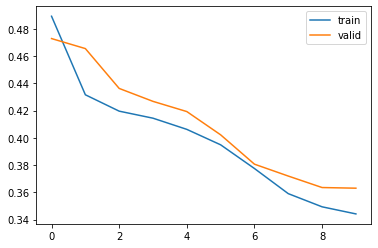

<IPython.core.display.Javascript object>

In [44]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#### Evaluate the model

In [45]:
# use evaluate function
score1 = model.evaluate(X_test, y_test)

94/94 [==============================] - 0s 778us/step - loss: 0.3565 - accuracy: 0.8577


<IPython.core.display.Javascript object>

**Observations:**

1. We see that the model has acheived around 85% accuracy which is lesser than the accuracy that RandomForestClassifier gave.
2. We have noticed that the dataset is imbalanced and contains less records of customers that have exited the bank. With this data the model will be able to identify the customer that is willing to leave about 85 times out of 100.

#### Print confusion matrix

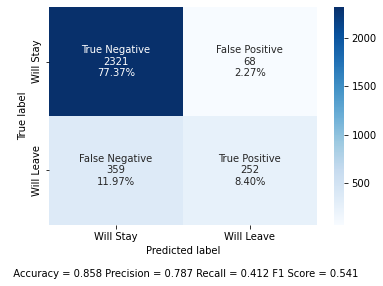

<IPython.core.display.Javascript object>

In [46]:
## Confusion Matrix on unsee test set
y_pred1 = model.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0

cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Will Stay','Will Leave']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**

1. We see that accuracy of the model has reduced compared to RandomForestClassifier.
2. The model has identified 68 customers as False Positives and classified them as the ones that would leave the bank.
3. The model has identified 359 customers that would stay compared to the data which shows them as they would continue.

#### ROC Curve

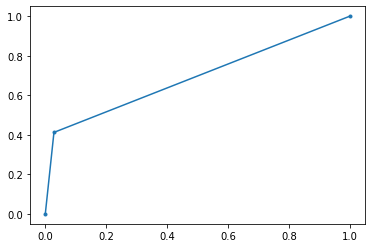

<IPython.core.display.Javascript object>

In [47]:
# instantiate the roc_curve
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred1)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)

# plot the graph
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.')

#### Find threshold using AUC Score

In [48]:
# find the optimum threshold using the the auc score
optimal_idx = np.argmax(nn_tpr_keras - nn_fpr_keras)
optimal_threshold_auc_roc = nn_thresholds_keras[optimal_idx]
print(optimal_threshold_auc_roc)

1.0


<IPython.core.display.Javascript object>

**Observations:**

1. As per ROC-AUC the optimum threshold value as 1.
2. We need to find a way to reduce the number of False_Negatives.
3. We need to try building another model with different activation function like 'sigmoid' and optimizer as 'sgd'


#### Model 2

- We will use a simple NN made of 5 fully-connected layers with ReLu activation. The NN takes a vector of length 11 as input. This represents the information related to each transactions, ie each line with 11 columns from the dataset. For each transaction, the final layer will output a probability distribution (sigmoid activation function) and classify either the customer will leave bank or not.
- a dropout step is included to prevent overfitting.

#### Create the model

In [49]:
#initialize the model
model2 = Sequential()

<IPython.core.display.Javascript object>

#### Add layers

In [50]:
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
model2.add(Dense(units=5, input_dim = 11,activation='sigmoid'))   # input of 11 columns as shown above

# hidden layer
model2.add(Dense(128,activation='sigmoid'))

# Adding the output layer
# We use the sigmoid because we want probability outcomes
model2.add(Dense(1,activation='sigmoid'))                        # binary classification leaving or not

<IPython.core.display.Javascript object>

#### Compile the model

In [51]:
# Create optimizer with default learning rate
# Compile the model
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

<IPython.core.display.Javascript object>

#### Model summary

In [52]:
# use summary function to check the model details
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 60        
                                                                 
 dense_4 (Dense)             (None, 128)               768       
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 957
Trainable params: 957
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

#### Train the model

In [53]:
#fitting the model
history2=model2.fit(X_train,y_train,batch_size=50,epochs=50,validation_split=0.2)

Epoch 1/50
112/112 [==============================] - 0s 2ms/step - loss: 0.4989 - accuracy: 0.8002 - val_loss: 0.5148 - val_accuracy: 0.7807
Epoch 2/50
112/112 [==============================] - 0s 1ms/step - loss: 0.4801 - accuracy: 0.8002 - val_loss: 0.4990 - val_accuracy: 0.7807
Epoch 3/50
112/112 [==============================] - 0s 981us/step - loss: 0.4612 - accuracy: 0.8002 - val_loss: 0.4752 - val_accuracy: 0.7807
Epoch 4/50
112/112 [==============================] - 0s 891us/step - loss: 0.4453 - accuracy: 0.8004 - val_loss: 0.4603 - val_accuracy: 0.7843
Epoch 5/50
112/112 [==============================] - 0s 943us/step - loss: 0.4334 - accuracy: 0.8023 - val_loss: 0.4575 - val_accuracy: 0.7886
Epoch 6/50
112/112 [==============================] - 0s 1ms/step - loss: 0.4274 - accuracy: 0.8098 - val_loss: 0.4481 - val_accuracy: 0.8036
Epoch 7/50
112/112 [==============================] - 0s 898us/step - loss: 0.4242 - accuracy: 0.8130 - val_loss: 0.4546 - val_accuracy: 0.796

<IPython.core.display.Javascript object>

#### Check the training and test loss

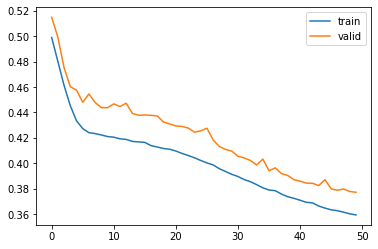

<IPython.core.display.Javascript object>

In [54]:
# Capturing learning history per epoch
hist2  = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch

# Plotting accuracy at different epochs
plt.plot(hist2['loss'])
plt.plot(hist2['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#### Evaluate the model

In [55]:
# evaluate the model
score2 = model2.evaluate(X_test, y_test)

94/94 [==============================] - 0s 1ms/step - loss: 0.3687 - accuracy: 0.8507


<IPython.core.display.Javascript object>

#### Print confusion matrix

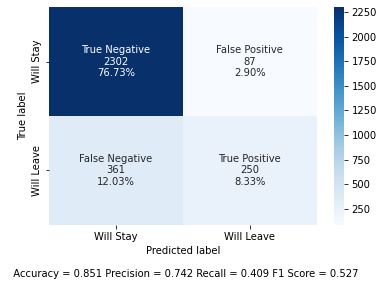

<IPython.core.display.Javascript object>

In [56]:
# predict the outcome and draw confusioln matrix
y_pred2 = model2.predict(X_test)
for i in range(len(y_test)):
    if y_pred2[i]>0.5:
        y_pred2[i]=1 
    else:
        y_pred2[i]=0

cm3=confusion_matrix(y_test, y_pred2)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Will Stay','Will Leave']
make_confusion_matrix(cm3, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**

1. We see that the model accuracy has decreased.
2. Number of false postives and false negatives have increased.
3. Let us try and build another model with hyper parameters.

#### ROC Curve

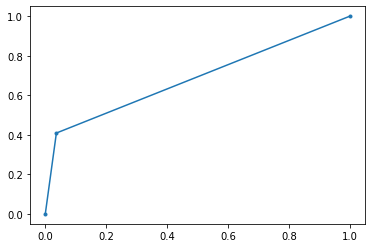

<IPython.core.display.Javascript object>

In [57]:
# instantiate the roc_curve
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred2)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)

# plot the graph
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.')

#### Find threshold using AUC score

In [58]:
# find the optimum threshold using the the auc score
optimal_idx = np.argmax(nn_tpr_keras - nn_fpr_keras)
optimal_threshold_auc_roc = nn_thresholds_keras[optimal_idx]
print(optimal_threshold_auc_roc)

1.0


<IPython.core.display.Javascript object>

**Observations:**

Threshold has not changed.

#### Model -3

We can try another architecture and use hyperparameters like EarlyStopping

#### Define hyperparameters

In [59]:
# adding earlystopping callback
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=15,
                              verbose=0, mode='min', restore_best_weights= True)

<IPython.core.display.Javascript object>

#### Create the model

In [60]:
# instantiate sequential
model3 = Sequential()

<IPython.core.display.Javascript object>

#### Add layers

In [61]:
# Initializing the hidden layer uisng hue_normal 
model3.add(Dense(1, kernel_initializer='he_normal', activation='relu'))

# adding output layer
model3.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

<IPython.core.display.Javascript object>

#### Compile the model

In [62]:
# compile the model
model3.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

<IPython.core.display.Javascript object>

#### Train the model

In [63]:
# train the model
history3= model3.fit(X_train, y_train, validation_split=0.2, batch_size=10, epochs=10, callbacks=[es], shuffle=True, verbose=1)

Epoch 1/10
560/560 [==============================] - 1s 2ms/step - loss: 0.6907 - accuracy: 0.6429 - val_loss: 0.6055 - val_accuracy: 0.7657
Epoch 2/10
560/560 [==============================] - 1s 1ms/step - loss: 0.5613 - accuracy: 0.7977 - val_loss: 0.5490 - val_accuracy: 0.7807
Epoch 3/10
560/560 [==============================] - 1s 1ms/step - loss: 0.5200 - accuracy: 0.8002 - val_loss: 0.5276 - val_accuracy: 0.7807
Epoch 4/10
560/560 [==============================] - 1s 970us/step - loss: 0.4988 - accuracy: 0.8004 - val_loss: 0.5112 - val_accuracy: 0.7807
Epoch 5/10
560/560 [==============================] - 0s 680us/step - loss: 0.4790 - accuracy: 0.8050 - val_loss: 0.4901 - val_accuracy: 0.7879
Epoch 6/10
560/560 [==============================] - 0s 650us/step - loss: 0.4621 - accuracy: 0.8107 - val_loss: 0.4759 - val_accuracy: 0.7979
Epoch 7/10
560/560 [==============================] - 1s 1ms/step - loss: 0.4519 - accuracy: 0.8107 - val_loss: 0.4663 - val_accuracy: 0.8029


<IPython.core.display.Javascript object>

#### Plot train and test loss

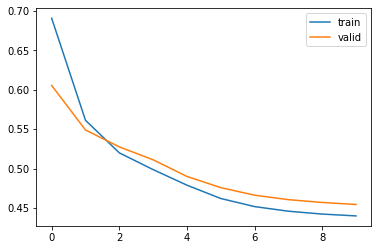

<IPython.core.display.Javascript object>

In [64]:
# Capturing learning history per epoch
hist3  = pd.DataFrame(history3.history)
hist3['epoch'] = history3.epoch

# Plotting accuracy at different epochs
plt.plot(hist3['loss'])
plt.plot(hist3['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#### Evaluate the model

In [65]:
# evaluate the model
score3 = model3.evaluate(X_test, y_test)

94/94 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.8167


<IPython.core.display.Javascript object>

#### Plot confusion matrix

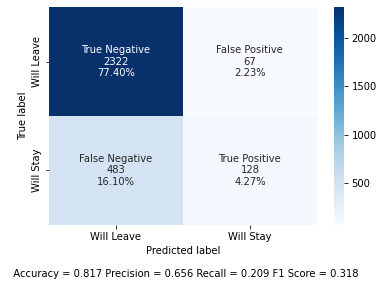

<IPython.core.display.Javascript object>

In [66]:
# predict the outcome and draw confusioln matrix
y_pred3 = model3.predict(X_test)
for i in range(len(y_test)):
    if y_pred3[i]>0.5:
        y_pred3[i]=1 
    else:
        y_pred3[i]=0



cm4=confusion_matrix(y_test, y_pred3)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Will Leave','Will Stay']
make_confusion_matrix(cm4, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Observations:**

1. We see that the accuracy and recall scores have further reduced.
2. Clearly this model is not the right fit.

### Compare model performance

In [67]:
# create dataframe
comparison_frame1 = pd.DataFrame({"Model":["Loss", "Accuracy"], 
                                        "Random Forest": score,
                                        "Model - 1": score1,
                                        "Model - 2": score2,
                                        "Model - 3": score3}
                                ) 
                                         
comparison_frame1

,Model,Random Forest,Model - 1,Model - 2,Model - 3
0,Loss,0.862333,0.356502,0.368746,0.435917
1,Accuracy,0.862333,0.857667,0.850667,0.816667


<IPython.core.display.Javascript object>

**Observations:**

1. RandomForest has given us the best accuracy, followed by Model - 1.
2. Since we are building ANN, recommendation to bank is to use Model - 1 as the model for future analysis and identification the customer that would leave the bank.

#### Evaluate the recommended model

Predicting the result of a single observation
Using this ANN model to predict if the customer with the following informations will leave the bank:

- Geography: France
- Credit Score: 600
- Gender: Male
- Age: 40 years old
- Tenure: 3 years
- Balance: $ 60000
- Number of Products: 2
- Does this customer have a credit card? Yes
- Is this customer an Active Member: Yes
- Estimated Salary: $ 50000

In [68]:
# we get the probability of this person leaving the bank.
print(model.predict(scaler.transform([[600, 40, 3, 60000, 2, 1, 1, 50000, 0, 0, 1]])))

[[0.05942276]]


<IPython.core.display.Javascript object>

**Observations:**

Our model recommends that this customer will stay with bank.

## Conclusion

1. There was imbalance in data, as it contains only 20% exited customers. This must be fixed for future analysis.
2. The bank can run the model to achieve desired performance levels for new data, also to offer better services to customers.
3. More data points can be added to dataset for better analysis in future.
4. We have built three models and have seen that the first ANN Model with 'relu' activation function gives us better performance.

## Recommendations

1. Bank can run promotions for the customers that are identified would exit.
2. Bank has to focus on getting customers to use Bank products more often, almost 50% customers are not actively using the products.
3. Bank can review customer profile and issue credit cards to the customers that do not hold the credit card. Factors like Age, CreditScore and EstimatedSalary can be used to arrive at the decisions for the same.
4. It is seen that most customers are from France and bank should improve the marketing strategy for other Geographies (Spain, Germany)
5. Bank can promote products to customers with lesser products and add to sales.
6. Age, Location, EstimatedSalary and CreditScore can be considered to devise a segementation based marketing, promotion and rewards strategy. 

In [69]:
# Module : Introduction to Neural Networks
# Project: Bank churn predictions
# Submitted by : Ritesh Sharma
# Submission Date :17 Dec 2021

<IPython.core.display.Javascript object>